# Generar dataset limpio

Qué hay que chequear:
* No son de entrenamiento
* Los tiempo de respuesta > a 7000 -> correct = 0
* No hay attempts < a 4

## Info sobre las pruebas

La cantidad de ejercicios es _sin contar entrenamiento_.

* Vocabulario (2022): 45 ejercicios - 34 SIN LAS FÁCILES
* Conciencia fonológica (2024): 20 ejercicios
* Sistema de escritura (2024): 10 ejercicios

accuracy_totales es count_correctas / count_max . Es decir sobre los valores que están arriba para cada prueba.
accuracy es el mean de las respuestas. --> (correct, mean)

In [157]:
import pandas as pd
import numpy as np

In [158]:
df_planilla=pd.read_csv("df_misiones.csv")
df_planilla

,Niño/a,Escuela / anexo,edad,ID
0,Melina Sosa,Jejy,6.0,6309-0005
1,Melina Sosa,Jejy,6.0,6309-0006
2,Melina Sosa,Jejy,6.0,6309-0008
3,Alexander Rodríguez,Jejy,5.0,6656-0008
4,Alexander Rodríguez,Jejy,5.0,6656-0009
...,...,...,...,...
138,Sandro Morinigo,Jejy,10.0,6309-0045
139,Clarita Benítez,Jejy,9.0,6656-0040
140,Cintia Benítez,Jejy,9.0,6656-0042
141,Marcos Morinigo,Jejy,8.0,6062-0042


In [159]:
column_names = [
    "Nombre",
    "Escuela",
    "Edad",
    "test_id"]
# Renombrar las columnas del DataFrame
df_planilla.columns = column_names
df_planilla

,Nombre,Escuela,Edad,test_id
0,Melina Sosa,Jejy,6.0,6309-0005
1,Melina Sosa,Jejy,6.0,6309-0006
2,Melina Sosa,Jejy,6.0,6309-0008
3,Alexander Rodríguez,Jejy,5.0,6656-0008
4,Alexander Rodríguez,Jejy,5.0,6656-0009
...,...,...,...,...
138,Sandro Morinigo,Jejy,10.0,6309-0045
139,Clarita Benítez,Jejy,9.0,6656-0040
140,Cintia Benítez,Jejy,9.0,6656-0042
141,Marcos Morinigo,Jejy,8.0,6062-0042


In [160]:
# # Buscar filas duplicadas según "test_id"
duplicados_df = df_planilla[df_planilla.duplicated(subset="test_id", keep=False)]
duplicados_df.sort_values(by="Nombre")
# duplicados=duplicados_df.test_id.unique()

duplicados_df.sort_values(by="Nombre", inplace=True)
duplicados_df

C:\Users\pablo\AppData\Local\Temp\ipykernel_18456\2021675128.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicados_df.sort_values(by="Nombre", inplace=True)


,Nombre,Escuela,Edad,test_id


#### Dejo las duplicadas para luego quedarme con la correcta cuando hago el merge. La incorrecta por ahora se pierde

### Cargo la data del server y elimino duplicados

In [161]:
df_server = pd.read_csv("data_server.csv")  
df_server.drop_duplicates(inplace=True)
df_server.shape

(5047, 25)

#### Saco los ítems fáciles, las pruebas de entrenamiento y > 7000 ms -> correcto = 0

In [162]:
df_server = df_server.drop(df_server[df_server["level_name"] == "entrenamiento"].index)


lista_faciles = [
    "esp2022-mochila",
    "esp2022-pantalon",
    "esp2022-limpio",
    "esp2022-gato",
    "esp2022-caballo",
    "esp2022-casa",
    "esp2022-anteojo",
    "esp2022-dormir",
    "esp2022-rojo",
    "esp2022-lapiz",
    "esp2022-llorar"
]

df_server = df_server[~df_server["object1_name"].isin(lista_faciles)]
df_server.shape


(4478, 25)

In [163]:
df_server.query("correct == 1").shape

(3416, 25)

In [164]:
df_server.loc[ df_server.query("object_touched_at > 7000").index, "correct" ] = 0
df_server.query("correct == 1").shape

(3194, 25)

### Unifico valores de test_name

In [173]:
test_map = {
       'sistemaEscritura2024-16':'sistemaEscritura2024-B',
       'sistemaEscritura2024-15': 'sistemaEscritura2024-A',
       'esp2022-5' :'esp2022-A',
       'esp2022-6':'esp2022-B',
       'concienciaFonologica2024-2':"concienciaFonologica2024-B",
       'concienciaFonologica2024-1':'concienciaFonologica2024-A'}

df_server['test_name'] = df_server['test_name'].replace(test_map)

df_server.test_name.value_counts()

esp2020                             2682
espL2                                751
concienciaFonologicaIndigena2024     440
concienciaFonologica2024             220
sistemaEscrituraIndigena2024         200
sistemaEscritura2024                 110
maternal2022                          41
esp2022                               34
Name: test_name, dtype: int64

In [181]:
df_server.groupby(["test_id","test_name"], as_index=False).count().value_counts("test_name")

test_name
esp2020                             56
concienciaFonologicaIndigena2024    22
sistemaEscrituraIndigena2024        20
espL2                               18
concienciaFonologica2024            11
sistemaEscritura2024                11
esp2022                              1
maternal2022                         1
dtype: int64

In [176]:
df_server.groupby(["test_id","test_name"], as_index=False).count().value_counts("test_name").sum()

140

In [180]:
# Filtrar los test_id de df_planilla que no están en df_server
test_ids_faltantes = df_planilla[~df_planilla["test_id"].isin(df_server["test_id"])]

# Mostrar los valores únicos faltantes (opcional)
ids_faltantes = test_ids_faltantes["test_id"].unique()
ids_faltantes

array(['6656-0008', '6309-0012', '6309-0028'], dtype=object)

In [166]:
# 1. Crear la nueva columna 'version'
df_server["version"] = df_server["test_name"].str.split("-").str[-1]

In [167]:
# 1. Elimino la versión de la columna test_name
df_server["test_name"] = df_server["test_name"].str.split("-").str[0]
df_server

,uuid,test_id,test_name,device,date,session_started_at,session_ended_at,trial_number_session,trial_started_at,repetition,...,object2_name,mandy_touch_diff_time,object_asked,object_asked_position,object_touched,object_touched_position,object_touched_at,correct,count_rewards,version
5,7E9B3F45D61F47FD886745E283A3FEA1,6062-0002,esp2020,6062,2024-11-11,2024-11-11T12:19:38.000Z,2024-11-11T12:31:15.000Z,6,2024-11-11T12:20:56.274Z,0,...,esp2020-aguja,1249,esp2020-lana,CENTER_LEFT,esp2020-lana,CENTER_LEFT,3010,1,4,A
6,7E9B3F45D61F47FD886745E283A3FEA1,6062-0002,esp2020,6062,2024-11-11,2024-11-11T12:19:38.000Z,2024-11-11T12:31:15.000Z,7,2024-11-11T12:21:07.886Z,0,...,esp2020-paja,5906,esp2020-paja,CENTER_RIGHT,esp2020-raiz,CENTER_LEFT,4060,0,4,A
7,7E9B3F45D61F47FD886745E283A3FEA1,6062-0002,esp2020,6062,2024-11-11,2024-11-11T12:19:38.000Z,2024-11-11T12:31:15.000Z,8,2024-11-11T12:21:25.157Z,0,...,esp2020-tornillo,456,esp2020-tornillo,CENTER_RIGHT,esp2020-tornillo,CENTER_RIGHT,3680,1,4,A
8,7E9B3F45D61F47FD886745E283A3FEA1,6062-0002,esp2020,6062,2024-11-11,2024-11-11T12:19:38.000Z,2024-11-11T12:31:15.000Z,9,2024-11-11T12:21:36.571Z,0,...,esp2020-remera,536,esp2020-remera,CENTER_RIGHT,esp2020-remera,CENTER_RIGHT,1806,1,4,A
9,7E9B3F45D61F47FD886745E283A3FEA1,6062-0002,esp2020,6062,2024-11-11,2024-11-11T12:19:38.000Z,2024-11-11T12:31:15.000Z,10,2024-11-11T12:21:46.191Z,0,...,esp2020-limpio,485,esp2020-sucio,CENTER_LEFT,esp2020-sucio,CENTER_LEFT,2463,1,4,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9373,4C5FCDCA8EA24D87B5FBB3C3729AEBD7,6309-0065,espL2,6309,2024-11-14,2024-11-14T17:20:28.000Z,2024-11-14T17:29:07.000Z,41,2024-11-14T17:28:08.019Z,0,...,espL2-2023-naranja,335,espL2-2023-naranja,CENTER_RIGHT,espL2-2023-naranja,CENTER_RIGHT,3500,1,4,A
9374,4C5FCDCA8EA24D87B5FBB3C3729AEBD7,6309-0065,espL2,6309,2024-11-14,2024-11-14T17:20:28.000Z,2024-11-14T17:29:07.000Z,42,2024-11-14T17:28:19.185Z,0,...,espL2-2023-lejos,2351,espL2-2023-lejos,CENTER_RIGHT,espL2-2023-lejos,CENTER_RIGHT,3832,1,4,A
9375,4C5FCDCA8EA24D87B5FBB3C3729AEBD7,6309-0065,espL2,6309,2024-11-14,2024-11-14T17:20:28.000Z,2024-11-14T17:29:07.000Z,43,2024-11-14T17:28:32.696Z,0,...,espL2-2023-infla,765,espL2-2023-patea,CENTER_LEFT,espL2-2023-infla,CENTER_RIGHT,4831,0,4,A
9376,4C5FCDCA8EA24D87B5FBB3C3729AEBD7,6309-0065,espL2,6309,2024-11-14,2024-11-14T17:20:28.000Z,2024-11-14T17:29:07.000Z,44,2024-11-14T17:28:45.567Z,0,...,espL2-2023-afuera,166,espL2-2023-afuera,CENTER_RIGHT,espL2-2023-afuera,CENTER_RIGHT,2451,1,4,A


#### Quedarte solo con correctas y sacar latency de eso

In [119]:
df_latency_correctas = df_server.query("correct == 1").groupby(["test_id","test_name"], as_index=False).agg(
    latency = ("object_touched_at", "mean")
)
df_latency_correctas



,test_id,test_name,latency
0,6062-0002,esp2020,2631.827586
1,6062-0003,esp2020,3124.920000
2,6062-0006,esp2020,1805.647059
3,6062-0007,esp2020,2295.032258
4,6062-0008,concienciaFonologicaIndigena2024,4113.111111
...,...,...,...
135,6656-0056,concienciaFonologicaIndigena2024,2227.857143
136,6656-0057,esp2020,2017.340909
137,6656-0058,concienciaFonologicaIndigena2024,1864.421053
138,6656-0059,sistemaEscrituraIndigena2024,1205.000000


#### Mergear las dos para obtener accuracy y latency_correctas

In [120]:
df = df_server.groupby(["test_id","test_name"], as_index=False).agg(
    
   
    cantidad_correctas = ("correct", "sum"),
    accuracy = ("correct", "mean"),
#   latency_general = ("object_touched_at", "mean"),
    attempts = ("correct", "count"),

    test_id = ("test_id", "first"),
    date = ("date", "first"),
    version = ("version", "first")
    
)
df

,test_name,cantidad_correctas,accuracy,attempts,test_id,date,version
0,esp2020,29,0.604167,48,6062-0002,2024-11-11,A
1,esp2020,25,0.520833,48,6062-0003,2024-11-11,B
2,esp2020,34,0.708333,48,6062-0006,2024-11-11,A
3,esp2020,31,0.645833,48,6062-0007,2024-11-11,B
4,concienciaFonologicaIndigena2024,9,0.450000,20,6062-0008,2024-11-11,A
...,...,...,...,...,...,...,...
135,concienciaFonologicaIndigena2024,14,0.700000,20,6656-0056,2024-11-14,B
136,esp2020,44,0.916667,48,6656-0057,2024-11-14,B
137,concienciaFonologicaIndigena2024,19,0.950000,20,6656-0058,2024-11-14,B
138,sistemaEscrituraIndigena2024,10,1.000000,10,6656-0059,2024-11-14,B


In [121]:
df["count_max"] = 34
df.loc[ df["test_name"] == "sistemaEscritura2024", "count_max" ] = 10
df.loc[ df["test_name"] == "concienciaFonologica2024", "count_max" ] = 20
df

,test_name,cantidad_correctas,accuracy,attempts,test_id,date,version,count_max
0,esp2020,29,0.604167,48,6062-0002,2024-11-11,A,34
1,esp2020,25,0.520833,48,6062-0003,2024-11-11,B,34
2,esp2020,34,0.708333,48,6062-0006,2024-11-11,A,34
3,esp2020,31,0.645833,48,6062-0007,2024-11-11,B,34
4,concienciaFonologicaIndigena2024,9,0.450000,20,6062-0008,2024-11-11,A,34
...,...,...,...,...,...,...,...,...
135,concienciaFonologicaIndigena2024,14,0.700000,20,6656-0056,2024-11-14,B,34
136,esp2020,44,0.916667,48,6656-0057,2024-11-14,B,34
137,concienciaFonologicaIndigena2024,19,0.950000,20,6656-0058,2024-11-14,B,34
138,sistemaEscrituraIndigena2024,10,1.000000,10,6656-0059,2024-11-14,B,34


In [122]:
df["accuracy_totales"] = df["cantidad_correctas"] / df["count_max"] 
df_data= pd.merge(df, df_latency_correctas, on = ["test_id","test_name" ])
df_data

,test_name,cantidad_correctas,accuracy,attempts,test_id,date,version,count_max,accuracy_totales,latency
0,esp2020,29,0.604167,48,6062-0002,2024-11-11,A,34,0.852941,2631.827586
1,esp2020,25,0.520833,48,6062-0003,2024-11-11,B,34,0.735294,3124.920000
2,esp2020,34,0.708333,48,6062-0006,2024-11-11,A,34,1.000000,1805.647059
3,esp2020,31,0.645833,48,6062-0007,2024-11-11,B,34,0.911765,2295.032258
4,concienciaFonologicaIndigena2024,9,0.450000,20,6062-0008,2024-11-11,A,34,0.264706,4113.111111
...,...,...,...,...,...,...,...,...,...,...
135,concienciaFonologicaIndigena2024,14,0.700000,20,6656-0056,2024-11-14,B,34,0.411765,2227.857143
136,esp2020,44,0.916667,48,6656-0057,2024-11-14,B,34,1.294118,2017.340909
137,concienciaFonologicaIndigena2024,19,0.950000,20,6656-0058,2024-11-14,B,34,0.558824,1864.421053
138,sistemaEscrituraIndigena2024,10,1.000000,10,6656-0059,2024-11-14,B,34,0.294118,1205.000000


In [123]:
df_data.query('attempts >34')
df_data = df_data.drop( columns = ["count_max", "cantidad_correctas"] )


In [124]:
# Buscar filas duplicadas según "test_id"
duplicados_server = df_data[df_data.duplicated(subset="test_id", keep=False)]
duplicados_server

,test_name,accuracy,attempts,test_id,date,version,accuracy_totales,latency


In [125]:
# df_data["id_and_test"]= df_data["test_id"] + df_data["test_name"]
# df_planilla["id_and_test"]= df_planilla["test_id"] + df_planilla["test_name"]

In [126]:
# df_planilla.shape

In [127]:
# # Filtrar los valores de df_planilla que no están en df_data
# valores_faltantes = df_planilla[~df_planilla["id_and_test"].isin(df_data["id_and_test"])]
# valores_faltantes
# # valores_faltantes.to_csv("faltantes.csv")

In [128]:
# valores_unicos = set(df_planilla["id_and_test"]) - set(df_data["id_and_test"])
# valores_faltantes = df_planilla[df_planilla["id_and_test"].isin(valores_unicos)]
# valores_faltantes.shape

In [129]:
# valores_faltantes.to_csv("errores_planillas.csv")

In [130]:
# valores_faltantes["op"] = valores_faltantes.codigo.str[5:7]

In [131]:
# valores_faltantes.value_counts("op")

In [135]:
# df_melted[ ~df_melted.duplicated(subset="test_id") ].shape

In [136]:
# df_data.merge(df_melted[ ~df_melted.duplicated(subset="test_id") ], on="test_id", how="inner")

In [142]:
merged_df=df_data.merge(df_planilla, on="test_id", how="inner")

* Caso solo entrenamiento
* Caso id que no corresponde con el server
* Caso que no estan las pruebas en el server

In [143]:
merged_df

,test_name,accuracy,attempts,test_id,date,version,accuracy_totales,latency,Nombre,Escuela,Edad
0,esp2020,0.604167,48,6062-0002,2024-11-11,A,0.852941,2631.827586,Iker Sosa,Jejy,5.0
1,esp2020,0.520833,48,6062-0003,2024-11-11,B,0.735294,3124.920000,Nayara Sosa,Jejy,4.0
2,esp2020,0.708333,48,6062-0006,2024-11-11,A,1.000000,1805.647059,Juan Carlos Sosa,Jejy,6.0
3,esp2020,0.645833,48,6062-0007,2024-11-11,B,0.911765,2295.032258,Jazmín Velázquez,Jejy,6.0
4,concienciaFonologicaIndigena2024,0.450000,20,6062-0008,2024-11-11,A,0.264706,4113.111111,Juan Carlos Sosa,Jejy,6.0
...,...,...,...,...,...,...,...,...,...,...,...
135,concienciaFonologicaIndigena2024,0.700000,20,6656-0056,2024-11-14,B,0.411765,2227.857143,Raquel,Pindo Poty,6.0
136,esp2020,0.916667,48,6656-0057,2024-11-14,B,1.294118,2017.340909,Junior,Pindo Poty,7.0
137,concienciaFonologicaIndigena2024,0.950000,20,6656-0058,2024-11-14,B,0.558824,1864.421053,Junior,Pindo Poty,7.0
138,sistemaEscrituraIndigena2024,1.000000,10,6656-0059,2024-11-14,B,0.294118,1205.000000,Junior,Pindo Poty,7.0


### Elijo columnas

In [144]:
merged_df = merged_df[[
    'test_id',
    'test_name',
    'version',
     
    'accuracy',
    'accuracy_totales',
    'attempts',
    'latency',    
    'date',
    
    'Nombre',    
    'Edad',    
    'Escuela',
]]

# merged_df.rename(columns= {'test_name_x':"test_name", 'test_id_x': 'test_id'} )

In [146]:
merged_df

,test_id,test_name,version,accuracy,accuracy_totales,attempts,latency,date,Nombre,Edad,Escuela
0,6062-0002,esp2020,A,0.604167,0.852941,48,2631.827586,2024-11-11,Iker Sosa,5.0,Jejy
1,6062-0003,esp2020,B,0.520833,0.735294,48,3124.920000,2024-11-11,Nayara Sosa,4.0,Jejy
2,6062-0006,esp2020,A,0.708333,1.000000,48,1805.647059,2024-11-11,Juan Carlos Sosa,6.0,Jejy
3,6062-0007,esp2020,B,0.645833,0.911765,48,2295.032258,2024-11-11,Jazmín Velázquez,6.0,Jejy
4,6062-0008,concienciaFonologicaIndigena2024,A,0.450000,0.264706,20,4113.111111,2024-11-11,Juan Carlos Sosa,6.0,Jejy
...,...,...,...,...,...,...,...,...,...,...,...
135,6656-0056,concienciaFonologicaIndigena2024,B,0.700000,0.411765,20,2227.857143,2024-11-14,Raquel,6.0,Pindo Poty
136,6656-0057,esp2020,B,0.916667,1.294118,48,2017.340909,2024-11-14,Junior,7.0,Pindo Poty
137,6656-0058,concienciaFonologicaIndigena2024,B,0.950000,0.558824,20,1864.421053,2024-11-14,Junior,7.0,Pindo Poty
138,6656-0059,sistemaEscrituraIndigena2024,B,1.000000,0.294118,10,1205.000000,2024-11-14,Junior,7.0,Pindo Poty


<Axes: ylabel='Frequency'>

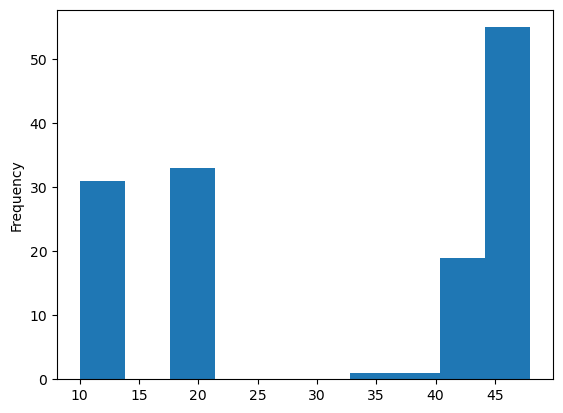

In [106]:
merged_df.attempts.plot.hist() 

### Saco attempts menores al 10% redondeando para abajo del total de cada prueba
    Vocabulario (2022): 45 ejercicios (finalmente usamos 34, que es sin las faciles)
    Conciencia fonológica (2024): 20 ejercicios
    Sistema de escritura (2024): 10 ejercicios


In [147]:
merged_df.test_name_x.unique()

AttributeError: 'DataFrame' object has no attribute 'test_name_x'

#### Vocabulario

In [ ]:
merged_df.query("attempts <= 3 and test_name_x == 'esp2022'").shape

#### Sistema de escritura

In [ ]:
merged_df.query("attempts <= 1 and test_name_x == 'sistemaEscritura2024'").shape

#### Conciencia Fonológica

In [ ]:
merged_df.shape

In [57]:
merged_df.query("attempts <= 2 and test_name_x == 'concienciaFonologica2024'").shape

(1, 17)

In [58]:
merged_df = merged_df.drop( merged_df.query("attempts <= 2 and test_name_x == 'concienciaFonologica2024'").index )

In [59]:
merged_df.shape

(1901, 17)

#### Fin

In [60]:
merged_df.attempts.value_counts(dropna=False)

34    644
20    618
10    599
9      18
19      4
8       3
26      2
6       2
7       2
5       1
16      1
21      1
23      1
18      1
11      1
12      1
14      1
15      1
Name: attempts, dtype: int64

Dado la cantidad de ejercicios que está más arriba los número parecerían estar bien

## Edad

In [61]:
fechas_nacimiento = merged_df.fecha_nac.str.replace("-","/").str.split("/", expand=True)

In [62]:
fechas_nacimiento = fechas_nacimiento.rename(columns={2: "año"})
df_filtrado = fechas_nacimiento.query('año.str.len() > 4')

fechas_nacimiento.loc[fechas_nacimiento["año"] == "29018", "año"] = "2018"
fechas_nacimiento.loc[fechas_nacimiento["año"] == "2918", "año"] = "2018"
fechas_nacimiento.loc[fechas_nacimiento["año"] == "2028", "año"] = "2018"
fechas_nacimiento.loc[fechas_nacimiento["año"] == "2029", "año"] = "2019"

fechas_nacimiento.loc[fechas_nacimiento["año"] == "20 19", "año"] = "2019"
fechas_nacimiento.loc[fechas_nacimiento["año"] == "20218", "año"] = "2018"
fechas_nacimiento.loc[fechas_nacimiento["año"] == "20219", "año"] = "2019"

In [63]:
fechas_nacimiento = fechas_nacimiento.rename(columns={"año": 2 })

### Pongo en el formato que corresponde

In [64]:
fechas_nacimiento[0] = fechas_nacimiento[0].str.strip()
fechas_nacimiento[1] = fechas_nacimiento[1].str.strip()
fechas_nacimiento[2] = fechas_nacimiento[2].str.strip()


#### Hay años que estan en 2 dígitos en vez de en 4

In [65]:
fechas_nacimiento[ fechas_nacimiento[2].str.len() == 2 ][2].value_counts(dropna=False)

Series([], Name: 2, dtype: int64)

In [66]:
fechas_nacimiento.loc[ fechas_nacimiento[2].str.len() == 2, 2] = "20" + fechas_nacimiento.loc[ fechas_nacimiento[2].str.len() == 2, 2]

In [67]:
fechas_nacimiento[ fechas_nacimiento[2].str.len() != 4 ].value_counts(dropna=False)

0           1    2    
05          03   20 19    3
1271272018  NaN  NaN      3
NaN         NaN  NaN      3
dtype: int64

In [68]:
fechas_nacimiento.loc[ fechas_nacimiento[2] == "20 19", 2 ] = "2019"

In [69]:
fechas_nacimiento[ fechas_nacimiento[2].str.len() != 4 ].value_counts(dropna=False)

0           1    2  
1271272018  NaN  NaN    3
NaN         NaN  NaN    3
dtype: int64

In [70]:
fechas_nacimiento.loc[ fechas_nacimiento[0] == "1271272018", 0 ] = None

In [71]:
fechas_nacimiento[ fechas_nacimiento[2].str.len() != 4 ].value_counts(dropna=False)

0    1    2  
NaN  NaN  NaN    6
dtype: int64

#### Hay tres dias que están mal

In [72]:
# fechas_nacimiento[ fechas_nacimiento[0].str.len() == 3 ]

In [73]:
# fechas_nacimiento.loc[ fechas_nacimiento[0].str.len() == 3, 0 ] = "22"

#### Check

In [74]:
fechas_nacimiento[ fechas_nacimiento[0].str.len() != 2 ]

,0,1,2
49,None,None,None
52,None,None,None
53,None,None,None
267,NaN,NaN,NaN
539,NaN,NaN,NaN
540,NaN,NaN,NaN


In [75]:
fechas_nacimiento[2].unique()

array(['2019', '2018', None, '2024', nan], dtype=object)

### Estamos ok

In [76]:
# Convertir a string y crear la columna de fecha
fechas_nacimiento["fecha_nacimiento"] = fechas_nacimiento[0].astype(str) + "-" + \
                                        fechas_nacimiento[1].astype(str) + "-" + \
                                        fechas_nacimiento[2].astype(str)

# Mostrar las primeras filas
fechas_nacimiento


,0,1,2,fecha_nacimiento
0,25,03,2019,25-03-2019
1,25,03,2019,25-03-2019
2,25,03,2019,25-03-2019
3,02,10,2018,02-10-2018
4,17,09,2018,17-09-2018
...,...,...,...,...
1897,03,05,2019,03-05-2019
1898,03,05,2019,03-05-2019
1899,15,08,2018,15-08-2018
1900,23,10,2018,23-10-2018


In [77]:
df_nan = fechas_nacimiento[fechas_nacimiento.isna().any(axis=1)]
df_nan

,0,1,2,fecha_nacimiento
49,None,None,None,None-None-None
52,None,None,None,None-None-None
53,None,None,None,None-None-None
267,NaN,NaN,NaN,nan-nan-nan
539,NaN,NaN,NaN,nan-nan-nan
540,NaN,NaN,NaN,nan-nan-nan


In [78]:
fechas_nacimiento["fecha_nacimiento"] = pd.to_datetime( fechas_nacimiento["fecha_nacimiento"],errors='coerce' )
merged_df["date"] = pd.to_datetime(merged_df["date"], errors='coerce')


C:\Users\pablo\AppData\Local\Temp\ipykernel_16644\959328220.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  fechas_nacimiento["fecha_nacimiento"] = pd.to_datetime( fechas_nacimiento["fecha_nacimiento"],errors='coerce' )


In [79]:
fechas_nacimiento[ pd.isna(fechas_nacimiento["fecha_nacimiento"]) ].shape

(9, 4)

In [80]:
merged_df.shape

(1901, 17)

In [81]:
df = merged_df.merge(fechas_nacimiento["fecha_nacimiento"], left_index=True, right_index=True)
df.shape

(1901, 18)

In [82]:
df["fecha_evaluacion"] = pd.to_datetime( df.date )

In [83]:
df["edad"] = ( (df["fecha_evaluacion"] - df["fecha_nacimiento"]) / np.timedelta64(1, 'D') ) / 30

In [84]:
df = df.drop( columns=["fecha_nac", "date"] )

#### Hay edades que están mal

<Axes: ylabel='Frequency'>

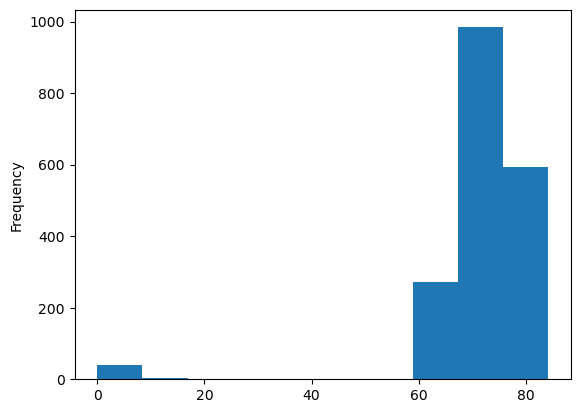

In [85]:
df.edad.plot.hist()

In [86]:
df.query("edad > 90").shape

(0, 18)

In [87]:
df.loc[ df.query("edad <= 40").index, "edad" ] = np.NaN

<Axes: ylabel='Frequency'>

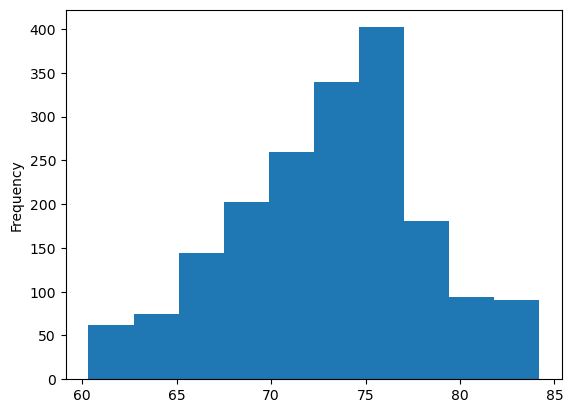

In [88]:
df.edad.plot.hist()

##### Gente sin edad (%):

In [89]:
df.query("edad != edad").shape[0] / df.query("edad == edad").shape[0]

0.02867965367965368

## Agrego columna NODO

In [90]:
# Cargar el archivo Excel que contiene la asignación de nodos
df_nodos = pd.read_excel("localidad_df.xlsx")  # Reemplaza con la ruta de tu archivo

# Asegurar que ambas columnas "jardin" sean del mismo tipo
df["localidad"] = df["localidad"].astype(str)
df_nodos["localidad"] = df_nodos["localidad"].astype(str)

# Unir los DataFrames usando "localidad" como clave
df = df.merge(df_nodos, on="localidad", how="left")
df

,test_name_x,version,test_id_x,accuracy,accuracy_totales,attempts,latency,codigo,genero,jardin,sala,supervision,localidad,ocup_padres,comentarios,fecha_nacimiento,fecha_evaluacion,edad,Nodo
0,esp2022,A,1685-0002,0.882353,0.882353,34,2004.766667,ER2413711,Masculino,Esc Edu Prim N 35,MULTIEDAD,Tala Zona Xvii - Mónica Londra,Durazno,EMPLEADO,NaN,2019-03-25,2024-12-04,69.366667,4
1,concienciaFonologica2024,B,1685-0003,0.400000,0.400000,20,2858.750000,ER2413711,Masculino,Esc Edu Prim N 35,MULTIEDAD,Tala Zona Xvii - Mónica Londra,Durazno,EMPLEADO,NaN,2019-03-25,2024-12-04,69.366667,4
2,sistemaEscritura2024,A,1685-0004,0.400000,0.400000,10,2208.750000,ER2413711,Masculino,Esc Edu Prim N 35,MULTIEDAD,Tala Zona Xvii - Mónica Londra,Durazno,EMPLEADO,NaN,2019-03-25,2024-12-04,69.366667,4
3,esp2022,A,2254-0001,0.529412,0.529412,34,4750.833333,ER2413401,Masculino,Ueni N 57,verde,Diamante Zona Xii - Miriam Elena Retegui,Diamante,Ama de casa,"Es un niño con TE, asiste al jardín con su aco...",2018-02-10,2024-11-14,82.300000,3
4,esp2022,B,2254-0002,0.941176,0.941176,34,3184.406250,ER2413402,Femenino,Ueni N 57,verde,Diamante Zona Xii - Miriam Elena Retegui,Diamante,Policia,NaN,2018-09-17,2024-11-14,75.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,esp2022,B,8447-0072,0.941176,0.941176,34,2574.562500,ER2411104,Femenino,Esc Edu Prim N 36,5,Concordia Zona V - Cecilia Julieta Garcia,Concordia,ama de casa,PRIMARIO COMPLETO,2019-03-05,2024-12-04,70.033333,2
1897,sistemaEscritura2024,B,8447-0073,0.900000,0.900000,10,1352.000000,ER2411104,Femenino,Esc Edu Prim N 36,5,Concordia Zona V - Cecilia Julieta Garcia,Concordia,ama de casa,PRIMARIO COMPLETO,2019-03-05,2024-12-04,70.033333,2
1898,esp2022,B,8447-0075,0.533333,0.235294,15,3769.750000,ER2412203,Femenino,Esc Edu Prim N 23,5 años,Parana Zona Ii - Claudio G. Lomagno,Paraná,NaN,NaN,2018-08-15,2024-12-17,77.200000,3
1899,esp2022,B,8447-0076,0.794118,0.794118,34,2973.222222,ER2412202,Femenino,Esc Edu Prim N 23,5 años,Parana Zona Ii - Claudio G. Lomagno,Paraná,NaN,NaN,2018-10-23,2024-12-17,74.900000,3


In [91]:
# Diccionario de mapeo
diccionario = {
    "1": "Federal",
    "2": "Concordia",
    "3": "Paraná",
    "4": "Gualeguaychú"
}

# Asegurarse de que la columna 'nodo' sea de tipo cadena y realizar la sustitución
df["Nodo"] = df["Nodo"].astype(str).map(diccionario).fillna(df["Nodo"])
df

,test_name_x,version,test_id_x,accuracy,accuracy_totales,attempts,latency,codigo,genero,jardin,sala,supervision,localidad,ocup_padres,comentarios,fecha_nacimiento,fecha_evaluacion,edad,Nodo
0,esp2022,A,1685-0002,0.882353,0.882353,34,2004.766667,ER2413711,Masculino,Esc Edu Prim N 35,MULTIEDAD,Tala Zona Xvii - Mónica Londra,Durazno,EMPLEADO,NaN,2019-03-25,2024-12-04,69.366667,Gualeguaychú
1,concienciaFonologica2024,B,1685-0003,0.400000,0.400000,20,2858.750000,ER2413711,Masculino,Esc Edu Prim N 35,MULTIEDAD,Tala Zona Xvii - Mónica Londra,Durazno,EMPLEADO,NaN,2019-03-25,2024-12-04,69.366667,Gualeguaychú
2,sistemaEscritura2024,A,1685-0004,0.400000,0.400000,10,2208.750000,ER2413711,Masculino,Esc Edu Prim N 35,MULTIEDAD,Tala Zona Xvii - Mónica Londra,Durazno,EMPLEADO,NaN,2019-03-25,2024-12-04,69.366667,Gualeguaychú
3,esp2022,A,2254-0001,0.529412,0.529412,34,4750.833333,ER2413401,Masculino,Ueni N 57,verde,Diamante Zona Xii - Miriam Elena Retegui,Diamante,Ama de casa,"Es un niño con TE, asiste al jardín con su aco...",2018-02-10,2024-11-14,82.300000,Paraná
4,esp2022,B,2254-0002,0.941176,0.941176,34,3184.406250,ER2413402,Femenino,Ueni N 57,verde,Diamante Zona Xii - Miriam Elena Retegui,Diamante,Policia,NaN,2018-09-17,2024-11-14,75.000000,Paraná
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,esp2022,B,8447-0072,0.941176,0.941176,34,2574.562500,ER2411104,Femenino,Esc Edu Prim N 36,5,Concordia Zona V - Cecilia Julieta Garcia,Concordia,ama de casa,PRIMARIO COMPLETO,2019-03-05,2024-12-04,70.033333,Concordia
1897,sistemaEscritura2024,B,8447-0073,0.900000,0.900000,10,1352.000000,ER2411104,Femenino,Esc Edu Prim N 36,5,Concordia Zona V - Cecilia Julieta Garcia,Concordia,ama de casa,PRIMARIO COMPLETO,2019-03-05,2024-12-04,70.033333,Concordia
1898,esp2022,B,8447-0075,0.533333,0.235294,15,3769.750000,ER2412203,Femenino,Esc Edu Prim N 23,5 años,Parana Zona Ii - Claudio G. Lomagno,Paraná,NaN,NaN,2018-08-15,2024-12-17,77.200000,Paraná
1899,esp2022,B,8447-0076,0.794118,0.794118,34,2973.222222,ER2412202,Femenino,Esc Edu Prim N 23,5 años,Parana Zona Ii - Claudio G. Lomagno,Paraná,NaN,NaN,2018-10-23,2024-12-17,74.900000,Paraná


## Grabo

In [92]:
df.to_csv("df-por_chico-clean_entrerios.csv", index=None)